In [1]:
# Create unique run id based on current time

from datetime import datetime
import os

os.makedirs('runs', exist_ok=True)
RUN_ID = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
conflicts = [run_id for run_id in os.listdir('runs') if run_id.startswith(RUN_ID)]
if conflicts:
    RUN_ID += f'_{len(conflicts)}'

In [2]:
# Authenticate Kaggle API

import json


KAGGLE_SECRETS_PATH = 'secrets/kaggle.json'

if os.path.exists(KAGGLE_SECRETS_PATH):
    with open(KAGGLE_SECRETS_PATH) as f:
        secrets = json.load(f)
        os.environ['KAGGLE_USERNAME'] = secrets['username']
        os.environ['KAGGLE_KEY'] = secrets['key']

In [3]:
# Download dataset

import kaggle


KAGGLE_DATASET = 'gpiosenka/cards-image-datasetclassification'
kaggle.api.dataset_download_files(KAGGLE_DATASET, path='raw_data', unzip=True)

In [4]:
# Convert dataset to 4 classes

from tqdm import tqdm
import shutil


if os.path.exists('data'):
    shutil.rmtree('data')
os.makedirs('data')

for split in ['train', 'test', 'valid']:
    data_map = {'hearts': [], 'diamonds': [], 'clubs': [], 'spades': []}

    for cls in tqdm(os.listdir(f'raw_data/{split}'), desc=split):
        new_cls = cls.split()[-1]
        if new_cls in data_map:
            data_map[new_cls].extend([f'raw_data/{split}/{cls}/{x}' for x in os.listdir(f'raw_data/{split}/{cls}') if x.endswith('.jpg')])

    os.makedirs(f'data/{split}')
    for cls in tqdm(data_map, desc=split):
        os.makedirs(f'data/{split}/{cls}')
        for i, img in enumerate(data_map[cls]):
            shutil.copy(img, f'data/{split}/{cls}/{cls}.{i}.jpg')

shutil.rmtree('raw_data')

valid: 100%|██████████| 4/4 [00:00<00:00, 110.91it/s]


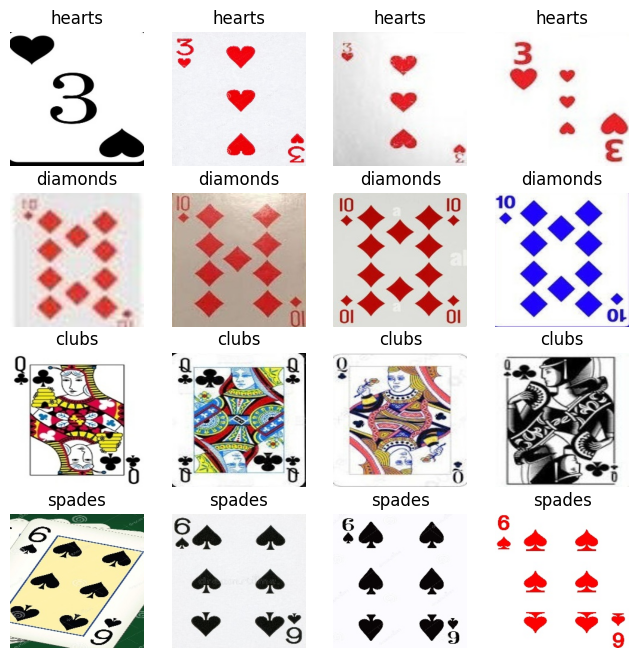

In [5]:
# Visualize dataset

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

fig, ax = plt.subplots(4, 4, figsize=(8, 8))
for i, cls in enumerate(['hearts', 'diamonds', 'clubs', 'spades']):
    for j in range(4):
        img = mpimg.imread(f'data/train/{cls}/{cls}.{random.randint(0, 100)}.jpg')
        ax[i, j].imshow(img)
        ax[i, j].axis('off')
        ax[i, j].set_title(cls)
plt.show()

In [6]:
# Create data generators

from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(
    rescale=1./255,
    # Random Augmentation only for training data
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'data/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical', 
    # Shuffle only for training data
    shuffle=True,
    seed=42
)

valid_generator = test_datagen.flow_from_directory(
    'data/valid',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    'data/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 7509 images belonging to 4 classes.
Found 260 images belonging to 4 classes.
Found 260 images belonging to 4 classes.


In [7]:
# Define model with 4 class output

import tensorflow as tf
import tensorflow_hub as hub


FEATURE_EXTRACTOR = 'https://www.kaggle.com/models/google/mobilenet-v1/frameworks/TensorFlow2/variations/025-224-feature-vector/versions/2'
feature_extractor = hub.KerasLayer(FEATURE_EXTRACTOR, input_shape=(224, 224, 3))
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Dense(4, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 256)               218544    
                                                                 
 dense (Dense)               (None, 4)                 1028      
                                                                 
Total params: 219572 (857.70 KB)
Trainable params: 1028 (4.02 KB)
Non-trainable params: 218544 (853.69 KB)
_________________________________________________________________


In [8]:
# Tensorboard callback with learning rate

from keras import backend as K
from keras.callbacks import TensorBoard

class LRTensorBoard(TensorBoard):
    def __init__(self, log_dir, **kwargs):
        super().__init__(log_dir=log_dir, **kwargs)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs.update({'lr': K.eval(self.model.optimizer.lr)})
        super().on_epoch_end(epoch, logs)

In [9]:
# Compile and train last layer first

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

tensorboard_dir = f'runs/{RUN_ID}/tensorboard'
callbacks = [
    LRTensorBoard(tensorboard_dir),
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
]

history_tl = model.fit(
    train_generator,
    validation_data=valid_generator,
    callbacks=callbacks,
    epochs=1000
)


Epoch 1/1000
235/235 [==============================] - 36s 150ms/step - loss: 1.2309 - accuracy: 0.4702 - val_loss: 0.8292 - val_accuracy: 0.6423 - lr: 0.0010
Epoch 2/1000
235/235 [==============================] - 35s 147ms/step - loss: 0.8126 - accuracy: 0.6539 - val_loss: 0.6738 - val_accuracy: 0.7000 - lr: 0.0010
Epoch 3/1000
235/235 [==============================] - 35s 147ms/step - loss: 0.7349 - accuracy: 0.6993 - val_loss: 0.6165 - val_accuracy: 0.7154 - lr: 0.0010
Epoch 4/1000
235/235 [==============================] - 35s 147ms/step - loss: 0.6959 - accuracy: 0.7171 - val_loss: 0.5618 - val_accuracy: 0.7769 - lr: 0.0010
Epoch 5/1000
235/235 [==============================] - 36s 151ms/step - loss: 0.6739 - accuracy: 0.7254 - val_loss: 0.5505 - val_accuracy: 0.7769 - lr: 0.0010
Epoch 6/1000
235/235 [==============================] - 35s 148ms/step - loss: 0.6527 - accuracy: 0.7314 - val_loss: 0.5553 - val_accuracy: 0.7654 - lr: 0.0010
Epoch 7/1000
235/235 [==================

In [10]:
# evaluate the model

model.evaluate(test_generator)

9/9 [==============================] - 1s 59ms/step - loss: 0.5273 - accuracy: 0.7923


[0.5272740125656128, 0.7923076748847961]

In [11]:
# Unfreeze feature extractor

feature_extractor.trainable = True
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 256)               218544    
                                                                 
 dense (Dense)               (None, 4)                 1028      
                                                                 
Total params: 219572 (857.70 KB)
Trainable params: 214100 (836.33 KB)
Non-trainable params: 5472 (21.38 KB)
_________________________________________________________________


In [12]:
# Train whole model 

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

tensorboard_dir = f'runs/{RUN_ID}/tensorboard'
callbacks = [
    LRTensorBoard(tensorboard_dir),
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
]

history_ft = model.fit(
    train_generator,
    validation_data=valid_generator,
    callbacks=callbacks + [tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3, verbose=1)],
    initial_epoch=len(history_tl.epoch),
    epochs=len(history_tl.epoch) + 1000
)

Epoch 27/1026
235/235 [==============================] - 76s 312ms/step - loss: 0.5871 - accuracy: 0.7888 - val_loss: 0.2622 - val_accuracy: 0.9385 - lr: 0.0010
Epoch 28/1026
235/235 [==============================] - 80s 338ms/step - loss: 0.3614 - accuracy: 0.8807 - val_loss: 0.2292 - val_accuracy: 0.9577 - lr: 0.0010
Epoch 29/1026
235/235 [==============================] - 84s 355ms/step - loss: 0.3153 - accuracy: 0.9048 - val_loss: 0.4244 - val_accuracy: 0.8923 - lr: 0.0010
Epoch 30/1026
235/235 [==============================] - 86s 365ms/step - loss: 0.2804 - accuracy: 0.9173 - val_loss: 0.1954 - val_accuracy: 0.9538 - lr: 0.0010
Epoch 31/1026
235/235 [==============================] - 85s 360ms/step - loss: 0.2605 - accuracy: 0.9282 - val_loss: 0.1406 - val_accuracy: 0.9654 - lr: 0.0010
Epoch 32/1026
235/235 [==============================] - 87s 370ms/step - loss: 0.2459 - accuracy: 0.9343 - val_loss: 0.1280 - val_accuracy: 0.9808 - lr: 0.0010
Epoch 33/1026
235/235 [===========

In [13]:
# evaluate the model

model.evaluate(test_generator)

9/9 [==============================] - 1s 67ms/step - loss: 0.0762 - accuracy: 0.9885


[0.07617254555225372, 0.9884615540504456]

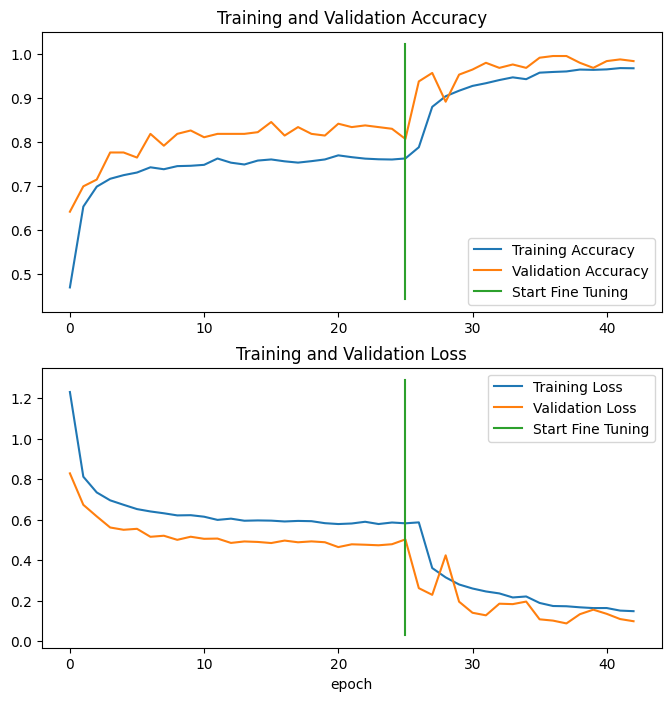

In [14]:
# merge history and plot

acc = history_tl.history['accuracy'] + history_ft.history['accuracy']
val_acc = history_tl.history['val_accuracy'] + history_ft.history['val_accuracy']
loss = history_tl.history['loss'] + history_ft.history['loss']
val_loss = history_tl.history['val_loss'] + history_ft.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([len(history_tl.epoch)-1, len(history_tl.epoch)-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([len(history_tl.epoch)-1,len(history_tl.epoch)-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [15]:
# Save the model in the TensorFlow SavedModel format

saved_model_path = f'runs/{RUN_ID}/saved_model'
model.save(saved_model_path)

INFO:tensorflow:Assets written to: runs/2024-03-05_08-51-05/saved_model/assets


INFO:tensorflow:Assets written to: runs/2024-03-05_08-51-05/saved_model/assets


In [16]:
js_model_path = f'runs/{RUN_ID}/js_model'

In [17]:
# Convert the model to the TensorFlow JS format

! tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model --signature_name=serving_default {saved_model_path} {js_model_path}

/Users/abinthomas/.pyenv/versions/3.11.7/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [18]:
# Bless the model, copy it to the 'webapp/blessed_model' directory (run only if the model is good)
import shutil

blessed_model_path = 'webapp/blessed_model'

if os.path.exists(blessed_model_path):
    shutil.rmtree(blessed_model_path)
shutil.copytree(js_model_path, blessed_model_path) 

# Save model class names on blessed model directory
import json
classes = sorted(os.listdir('../data/train'))
with open(f'{blessed_model_path}/class_names.json', 'w') as f:
    json.dump(classes, f)

'webapp/blessed_model'